Arpitha Gurumurthy </br>
Team: Amalgam
# **Factor: Style Based approaches for fake news detection**
There are mainly two typical categories of style-based
methods: 
* Deception-oriented
  * Deception-oriented stylometric methods capture the
deceptive statements or claims from news content.
  * Rhetorical structure theory can be utilized to capture
the differences between deceptive and truthful sentences
* Rhetoric - language designed to have a persuasive or impressive effect on its audience, but often regarded as lacking in sincerity or meaningful content

### Micro factors for Style based based on the above stated points:
* Hyperpartisan: Extremely one sided
* Yellow Journalism: relying on eye-catching headlines
* Rhetorical structure theory (for future work)

### Articles for reference:
* https://arxiv.org/pdf/1708.01967.pdf
* https://arxiv.org/pdf/1702.05638.pdf


Using Textstat for feature engineering - Textstat is an easy to use library to calculate statistics from text. It helps determine readability, complexity, and grade level.



In [ ]:
pip install textstat

     |████████████████████████████████| 102kB 4.3MB/s 
     |████████████████████████████████| 1.9MB 33.0MB/s 


In [ ]:
#Importing data from google sheets - politifact dataset
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import tensorflow.compat.v1 as tf
import textstat
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vSZ3xvKxpVPV-vjVBDj9gbBUiNG0blLQS4RtV5X1pIJ1oulJiQrReHm4wOSG1hs58aHBSJerqevF3Eh/pub?output=csv')
data = r.content
df_kaggle = pd.read_csv(BytesIO(data))
df_kaggle = df_kaggle.drop(columns='Unnamed: 0', axis=1)
df_kaggle = df_kaggle.drop(columns='Unnamed: 0.1', axis=1)
df_kaggle = df_kaggle.rename(columns={'Comment':'Text'})

In [ ]:
df_kaggle.head()

id  ... label
0  15290  ...     0
1  10732  ...     0
2  12026  ...     0
3   9694  ...     0
4  17166  ...     0

[5 rows x 5 columns]

In [ ]:
df_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4000 non-null   int64 
 1   headline    3889 non-null   object
 2   written_by  3622 non-null   object
 3   news        3972 non-null   object
 4   label       4000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 156.4+ KB


In [ ]:
df_kaggle.shape

(4000, 5)

## **EDA and Feature Engineering**

In [ ]:
##Dropping the columns that is not required in this usecase
# df_kaggle = df_kaggle.drop(columns='label', axis = 1)

In [ ]:
df_kaggle.news = df_kaggle.news.apply(str)
df_kaggle.headline = df_kaggle.headline.apply(str)

In [ ]:
##Creating a feature to count the number of words
df_kaggle['lex_count'] = df_kaggle['news'].apply(textstat.lexicon_count)

In [ ]:
##Creating a feature to count the number of difficult words
df_kaggle['difficult_count'] = df_kaggle['headline'].apply(textstat.difficult_words)

In [ ]:
##Creating a feature to count the number of sentences
df_kaggle['num_sentences'] = df_kaggle['news'].apply(textstat.sentence_count)

In [ ]:
##Creating a feature to count the number of syllable
df_kaggle['num_syllables'] = df_kaggle['news'].apply(textstat.syllable_count)

In [ ]:
##Creating a feature for flesch_kincaid_grade
df_kaggle['flesch_kincaid_grade'] = df_kaggle['news'].apply(textstat.flesch_kincaid_grade)

In [ ]:
##The Fog Scale (Gunning FOG Formula)
df_kaggle['gunning_fog'] = df_kaggle['headline'].apply(textstat.gunning_fog)

In [ ]:
##Creating a feature for avg number of syllables per word - 
df_kaggle['avg_syllables'] = df_kaggle['num_syllables'] / df_kaggle['lex_count']

In [ ]:
## Average sentence length
df_kaggle['avg_sentence_length'] = df_kaggle['lex_count'] / df_kaggle['num_sentences']

Calculating the Sentiment score for each record

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
##Looping to pass every headline into the analyser, a sentiment score is assigned to each headline.
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for headline in df_kaggle['news']:
    pol_score = sia.polarity_scores(headline)
    pol_score['headline'] = headline
    results.append(pol_score)

results

[{'compound': 0.9976,
  'headline': 'It’s not often a mother tries to persuade her teenage son to attend a music festival with her. But Desert Trip is not your average festival. On Friday night, an   team of classic rock veterans  —   the Rolling Stones, Bob Dylan, Paul McCartney, Neil Young, the Who and Roger Waters of Pink Floyd  —   will begin its first of two weekends on the same storied bill at the Empire Polo Club in Indio, Calif. Among the crowd will be Julie Varon, a mother of three from Seattle, who grew up on the rock ’n’ roll that once soundtracked and spurred the counterculture. Also taking part, though not entirely of his own volition: Ms. Varon’s    son, Sam, who prefers modern country music and Coachella, the annual pop festival that shares an organizer and location with Desert Trip. “This is definitely a little bit of a twist,” Sam said a few days before the event. His mother chimed in: “A twist of the arm. ” She added: “It didn’t help that people started calling it Old

In [ ]:
##Concatenating this list to our original dataframe, only interested in the values of the ‘compound’ variable.
df_kaggle['Sentiment_Score'] = pd.DataFrame(results)['compound']

In [ ]:
df_kaggle.head()

id  ... Sentiment_Score
0  15290  ...          0.9976
1  10732  ...          0.9952
2  12026  ...          0.9945
3   9694  ...          0.9744
4  17166  ...         -0.1280

[5 rows x 14 columns]

## **Defining the Deceptiveness quotient**


* **avg_sentence_length** : tells us the average number of words in each sentence of the text. 
* **avg_syllables** : tells us the average number of syllables in each word of the text.
* **flesch_kincaid_grade** : 
* **gunning_fog** : 
* **Sentiment_Score** : We take the magnitude (postive and negative) of this score and add it to deception score.


In [ ]:
## Score for deception
df_kaggle['deception_score'] = df_kaggle['avg_sentence_length'] + df_kaggle['avg_syllables'] * 10 + df_kaggle['flesch_kincaid_grade'] + df_kaggle['gunning_fog'] + abs(df_kaggle['Sentiment_Score'])

In [ ]:
df_kaggle.head()

id  ... deception_score
0  15290  ...       72.608628
1  10732  ...       51.320838
2  12026  ...       50.991671
3   9694  ...       74.709946
4  17166  ...      136.091333

[5 rows x 15 columns]

Segmenting the yellowness factor into 3 categories

In [ ]:
deceptiveness_factor = ['Not Deceptive', 'Deceptive']
df_kaggle['deceptiveness_factor'] = pd.qcut(df_kaggle['deception_score'], q=2, labels= deceptiveness_factor)
df_kaggle.head()

id  ... deceptiveness_factor
0  15290  ...            Deceptive
1  10732  ...        Not Deceptive
2  12026  ...        Not Deceptive
3   9694  ...            Deceptive
4  17166  ...            Deceptive

[5 rows x 16 columns]

## **Modeling**
### **Implementing muller loop**




In [ ]:
#Importing required libraries
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import pickle

In [ ]:
## Function to run various algorithms to find the best fit on our data
def muller_loop(muller_df):
  df_compare_muller = pd.DataFrame(columns=['Classifier','Accuracy/Score', 'Training Time'])
  import time as time
  import xgboost as xgb
  names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
          "Naive Bayes", "QDA", "MLP"]

  classifiers = [
      KNeighborsClassifier(2),
      SVC(kernel="linear", C=0.025),
      SVC(gamma=2, C=1),
      DecisionTreeClassifier(max_depth=5),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      MLPClassifier(alpha=1, max_iter=1000),
      AdaBoostClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis(),
      MLPClassifier()]
  X = df_kaggle[['avg_sentence_length','avg_syllables','flesch_kincaid_grade','gunning_fog','Sentiment_Score']]
  y = df_kaggle[['deceptiveness_factor']]
  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

  max_score = 0.0
  max_class = ''
  clf_best = ""
  model = ""
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      start_time = time.time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
      training_time = time.time() - start_time
      df_compare_muller.loc[-1] = [name, score, training_time]  # adding a row
      df_compare_muller.index = df_compare_muller.index + 1  # shifting index
      df_compare_muller = df_compare_muller.sort_index()

      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name
  print(df_compare_muller)
  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  print(80*'-' )
  print('Printing the confusion matrix for'+max_class)
  plot_confusion_matrix(clf_best, X_test, y_test, values_format=".1f", cmap=plt.cm.Reds)  
  plt.show()

  y_pred = clf_best.predict(X_test)
  print('Printing the Classification report for'+max_class)
  print(80*'-' )
  print(classification_report(y_test, y_pred))
  # save the model to disk
  filename = 'deception_model.sav'
  pickle.dump(clf_best, open(filename, 'wb'))
  return df_compare_muller


Classifier = Nearest Neighbors, Score (test, accuracy) = 93.38, Training time = 0.04 seconds
Classifier = Linear SVM, Score (test, accuracy) = 94.88, Training time = 0.10 seconds
Classifier = RBF SVM, Score (test, accuracy) = 97.00, Training time = 0.18 seconds
Classifier = Decision Tree, Score (test, accuracy) = 96.50, Training time = 0.01 seconds
Classifier = Random Forest, Score (test, accuracy) = 96.50, Training time = 0.04 seconds
Classifier = Neural Net, Score (test, accuracy) = 98.38, Training time = 1.99 seconds
Classifier = AdaBoost, Score (test, accuracy) = 99.00, Training time = 0.41 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 80.25, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 80.75, Training time = 0.01 seconds
Classifier = MLP, Score (test, accuracy) = 99.88, Training time = 3.54 seconds
          Classifier  Accuracy/Score  Training Time
0                MLP          99.875       3.541740
1                QDA          80.750     

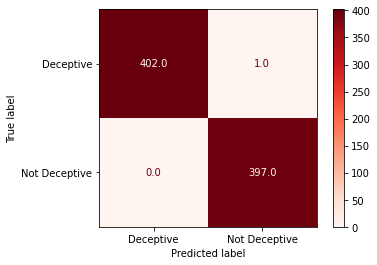

Printing the Classification report forMLP
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

    Deceptive       1.00      1.00      1.00       403
Not Deceptive       1.00      1.00      1.00       397

     accuracy                           1.00       800
    macro avg       1.00      1.00      1.00       800
 weighted avg       1.00      1.00      1.00       800



Classifier  Accuracy/Score  Training Time
0                MLP          99.875       3.541740
1                QDA          80.750       0.006253
2        Naive Bayes          80.250       0.007669
3           AdaBoost          99.000       0.411496
4         Neural Net          98.375       1.989525
5      Random Forest          96.500       0.040889
6      Decision Tree          96.500       0.014781
7            RBF SVM          97.000       0.176575
8         Linear SVM          94.875       0.099642
9  Nearest Neighbors          93.375       0.039710

In [ ]:
muller_loop(df_kaggle)

## **References**
* https://algotrading101.com/learn/sentiment-analysis-python-guide/
* https://github.com/Lucas170/Sentiment-Analysis-1-TSLA-Headlines
* https://github.com/aarsanjani/applied-ml-2020/blob/master/MullerLoop.ipynb
* https://link.springer.com/chapter/10.1007/3-540-44853-5_7
* https://pypi.org/project/textstat/

